# Import Necesssary Packages

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
from sklearn.utils import shuffle
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

In [2]:
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
import bisect
from scipy.sparse import hstack

# Read the data

In [3]:
kdd_data = pd.read_csv('/content/orange_small_train.txt', delimiter="\t")

In [4]:
kdd_data['appetency_labels'] = pd.read_table("/content/orange_small_train_appetency.labels", header = None, names = ['appetency'])
kdd_data['churn_labels'] = pd.read_table("/content/orange_small_train_churn.labels", header = None, names = ['churn'])
kdd_data['upselling_labels'] = pd.read_table("/content/orange_small_train_upselling (1).labels", header= None, names = ['upselling'])

In [5]:
kdd_data['appetency_labels'] = kdd_data['appetency_labels'].replace(-1, 0)
kdd_data['churn_labels'] = kdd_data['churn_labels'].replace(-1, 0)
kdd_data['upselling_labels'] = kdd_data['upselling_labels'].replace(-1, 0)

In [6]:
print("There are", kdd_data.shape[0], "observations and", kdd_data.shape[1], "variables")

There are 5997 observations and 233 variables


# Handling missing values

In [7]:
kdd_data.isna().sum()

Var1                5915
Var2                5849
Var3                5850
Var4                5819
Var5                5821
                    ... 
Var229              3395
Var230              5997
appetency_labels       0
churn_labels           0
upselling_labels       0
Length: 233, dtype: int64

## Drop column if over 40% of the columns are null values

In [8]:
columns= [cols for cols in kdd_data.columns if kdd_data[cols].isnull().sum()/kdd_data.shape[0] > 0.40] #Selecting columns that have over 40% of null values

In [9]:
kdd_data.drop(columns, axis = 1, inplace = True) #Dropping columns

In [10]:
len(kdd_data.columns)

70

In [11]:
kdd_data.dtypes #Types of the columns

Var6                float64
Var7                float64
Var13               float64
Var21               float64
Var22               float64
                     ...   
Var227               object
Var228               object
appetency_labels      int64
churn_labels          int64
upselling_labels      int64
Length: 70, dtype: object

In [12]:
kdd_data.isna().sum() # Number of null values in each column

Var6                635
Var7                640
Var13               640
Var21               635
Var22               584
                   ... 
Var227                1
Var228                1
appetency_labels      0
churn_labels          0
upselling_labels      0
Length: 70, dtype: int64

In [13]:
missing_data = pd.DataFrame({'Column': kdd_data.columns, 'NA_count': kdd_data.isna().sum()})

In [14]:
fig = px.bar(x= missing_data.Column, y=missing_data.NA_count, labels={'x':'Column', 'y':'Missing Value Count'}, title='Missing Value counts')
fig.show()

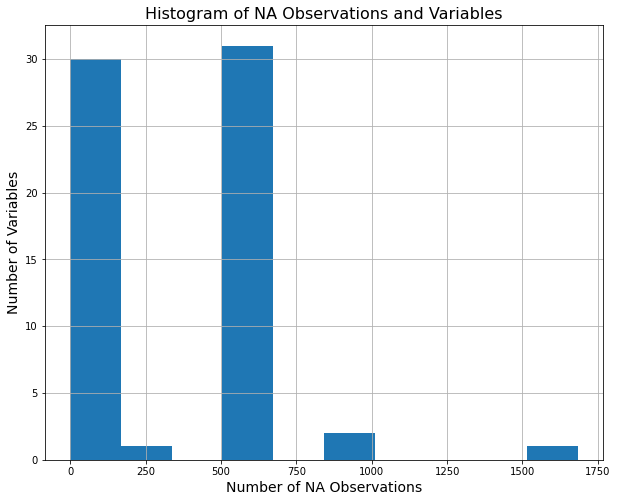

In [23]:
plt.figure(figsize = (10,8))
kdd_data.isna().sum().hist()
plt.title("Histogram of NA Observations and Variables", fontsize = 16)
plt.xlabel("Number of NA Observations", fontsize = 14)
plt.ylabel("Number of Variables", fontsize = 14)
plt.show()

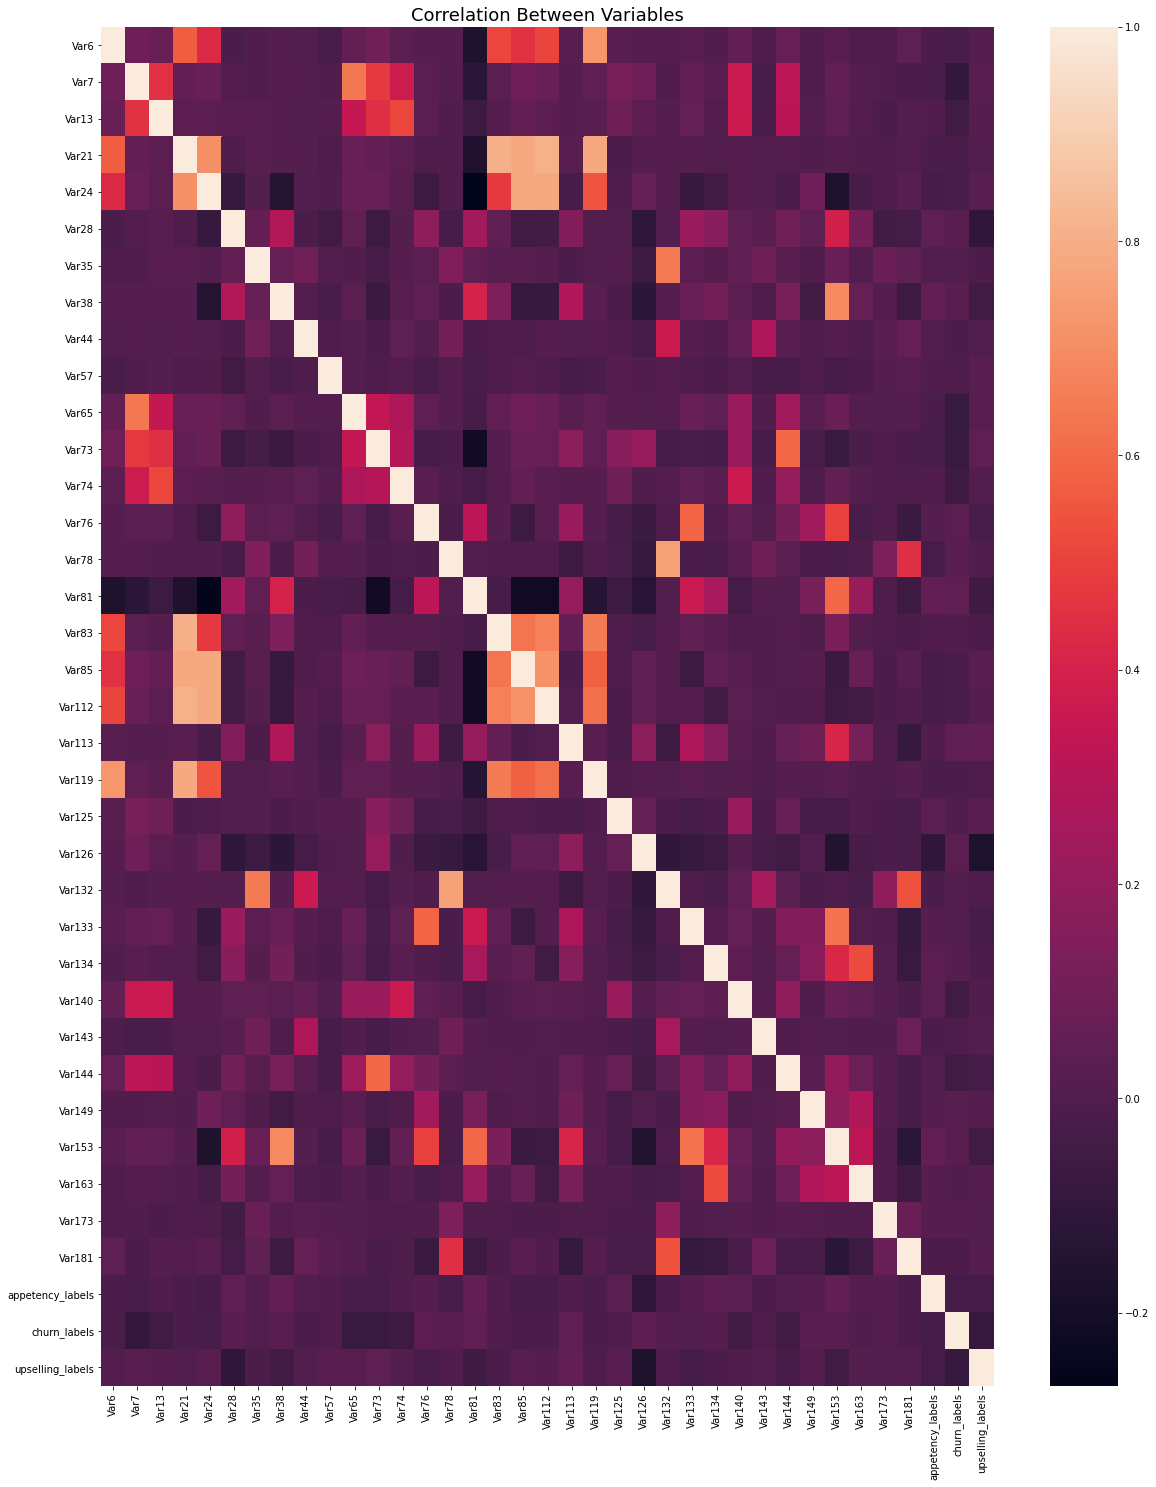

In [25]:
plt.figure(figsize=(20,25))
plt.title("Correlation Between Variables", fontsize = 18)
sns.heatmap(kdd_data.corr())


## Removing Highly correlated columns

In [16]:
corr_matrix = kdd_data.corr().abs()

In [17]:
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

In [18]:
to_drop = [column for column in upper.columns if any(upper[column] > 0.85)]

In [19]:
to_drop

['Var22', 'Var25', 'Var109', 'Var123', 'Var160']

In [20]:
kdd_data.drop(to_drop, axis=1, inplace=True)

## Handling Categorical Null Variables

In [21]:
cols=[col for col in kdd_data.columns if kdd_data[col].dtype=='O']

In [22]:
kdd_data[cols].isna().sum()

Var192     41
Var193      1
Var195      1
Var196      1
Var197     16
Var198      1
Var199      3
Var202      2
Var203     16
Var204      1
Var205    253
Var206    636
Var207      1
Var208     16
Var210      1
Var211      1
Var212      1
Var216      1
Var217     79
Var218     79
Var219    641
Var220      1
Var221      1
Var222      1
Var223    641
Var226      1
Var227      1
Var228      1
dtype: int64

### Number of Categories in each variable

In [26]:
cols_value_counts = [(i, kdd_data[i].nunique()) for i in cols] #Checking the number of unique values in each categorical variable

In [27]:
cols_value_counts

[('Var192', 273),
 ('Var193', 38),
 ('Var195', 19),
 ('Var196', 2),
 ('Var197', 176),
 ('Var198', 1656),
 ('Var199', 1288),
 ('Var202', 2920),
 ('Var203', 4),
 ('Var204', 100),
 ('Var205', 3),
 ('Var206', 20),
 ('Var207', 13),
 ('Var208', 2),
 ('Var210', 6),
 ('Var211', 2),
 ('Var212', 62),
 ('Var216', 704),
 ('Var217', 3688),
 ('Var218', 2),
 ('Var219', 11),
 ('Var220', 1656),
 ('Var221', 7),
 ('Var222', 1656),
 ('Var223', 4),
 ('Var226', 23),
 ('Var227', 7),
 ('Var228', 25)]

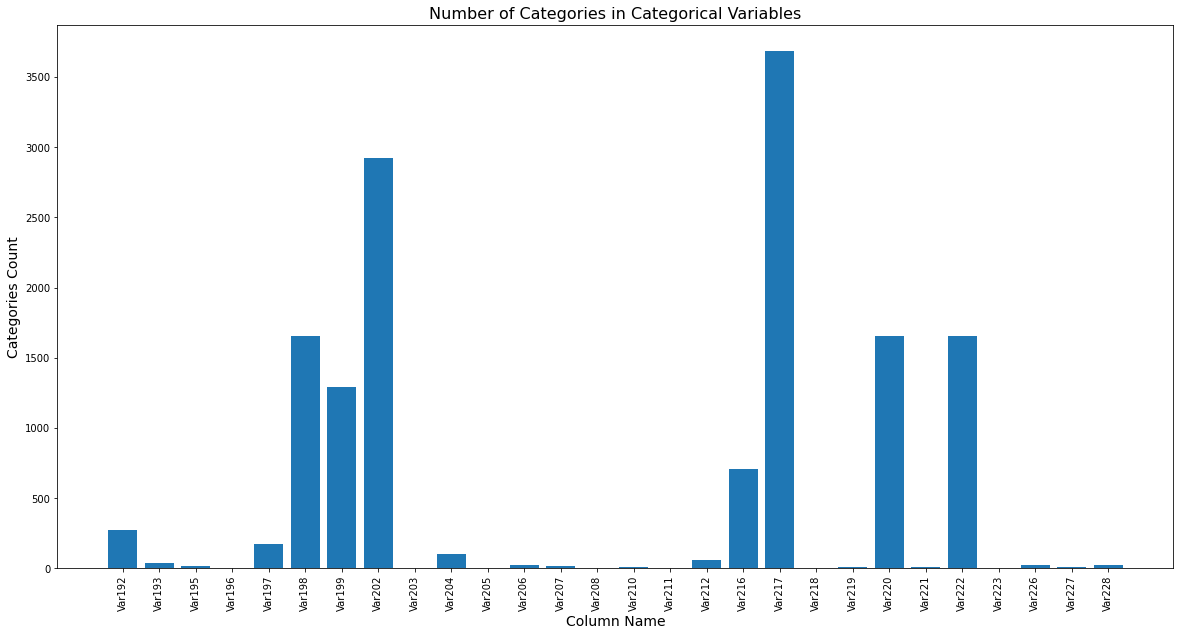

In [28]:
categories_num = {}
for i in cols:
    a = len(kdd_data[i].value_counts())
    categories_num[i] = a
    
plt.figure(figsize = (20,10))
plt.title("Number of Categories in Categorical Variables", fontsize = 16)
plt.bar(*zip(*categories_num.items()))
plt.xlabel("Column Name", fontsize = 14)
plt.xticks(rotation=90)
plt.ylabel("Categories Count", fontsize = 14)
plt.show()

#### To Keep things fairly simple and within the scope of the project, we only select categorical variables with less than 100 unique categories 

In [29]:
cols_new = [i for i in cols if kdd_data[i].nunique() < 100] #Selecting only those categorical variables with less than 

In [30]:
kdd_data[cols_new].isna().sum() #Null values in these columns

Var193      1
Var195      1
Var196      1
Var203     16
Var205    253
Var206    636
Var207      1
Var208     16
Var210      1
Var211      1
Var212      1
Var218     79
Var219    641
Var221      1
Var223    641
Var226      1
Var227      1
Var228      1
dtype: int64

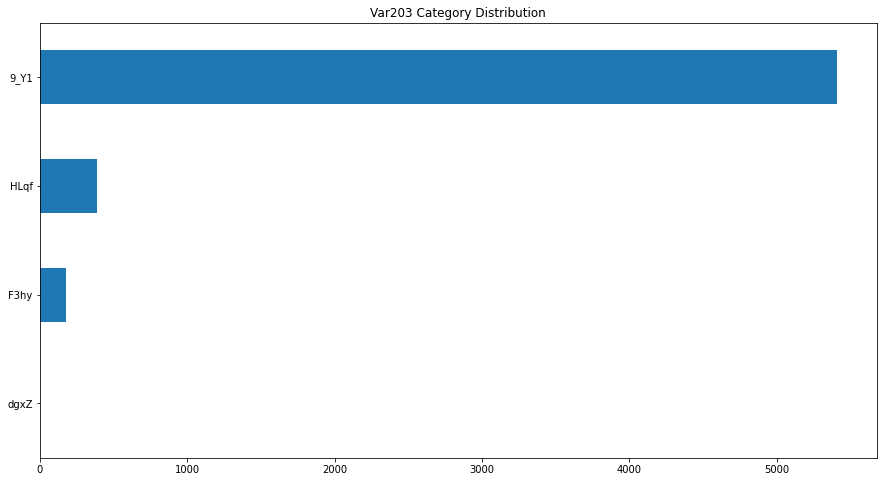

In [37]:
plt.figure(figsize = (15,8))
plt.title('Var203 Category Distribution')
kdd_data['Var203'].value_counts().sort_values().plot(kind = 'barh') #Distribution of each column

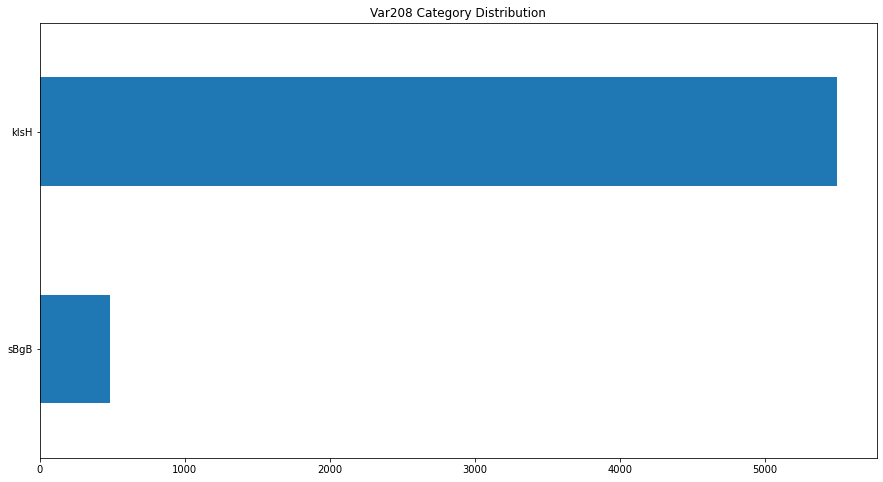

In [38]:
plt.figure(figsize = (15,8))
plt.title('Var208 Category Distribution')
kdd_data['Var208'].value_counts().sort_values().plot(kind = 'barh') #Distribution of each column

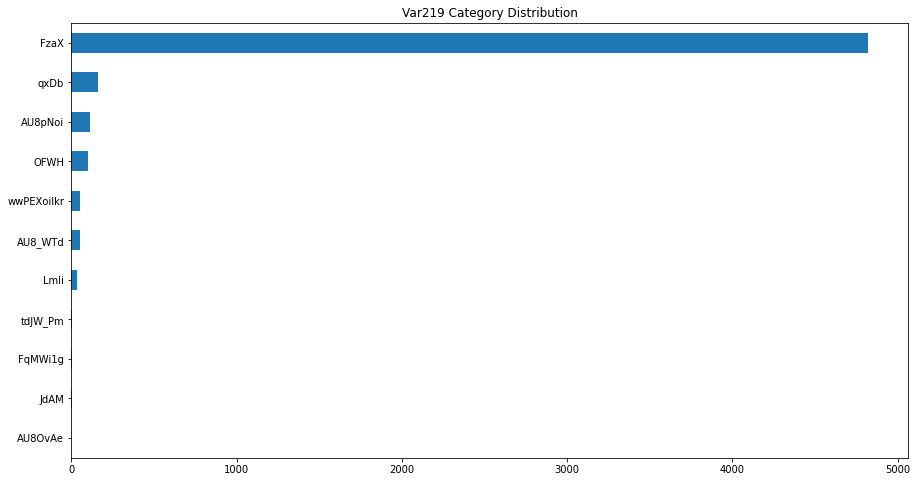

In [39]:
plt.figure(figsize = (15,8))
plt.title('Var219 Category Distribution')
kdd_data['Var219'].value_counts().sort_values().plot(kind = 'barh') #Distribution of each column

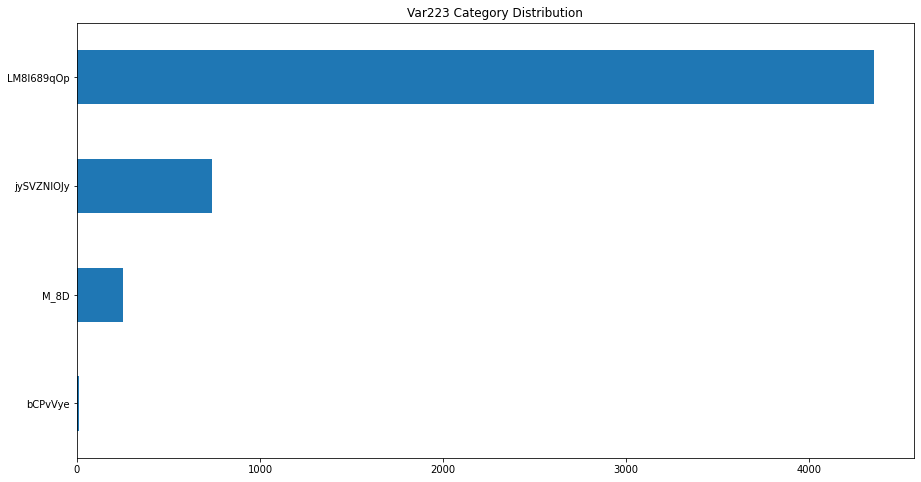

In [40]:
plt.figure(figsize = (15,8))
plt.title('Var223 Category Distribution')
kdd_data['Var223'].value_counts().sort_values().plot(kind = 'barh') #Distribution of each column

#### Using Mode of the class to fill missing values for categories that have a prominent major class. We use forward fill to handle other categorical column

In [41]:
#Using max frequency handling for the following columns 
kdd_data[['Var208', 'Var219', 'Var203', 'Var223']] = kdd_data[['Var208', 'Var219', 'Var203', 'Var223']].apply(lambda x:x.fillna(x.value_counts().index[0]))  

In [42]:
#Using forward fill for these columns
kdd_data[['Var205', 'Var206', 'Var218']]=kdd_data[['Var205', 'Var206', 'Var218']].ffill(axis=0)

In [43]:
kdd_data[cols_new].isna().sum()

Var193    1
Var195    1
Var196    1
Var203    0
Var205    0
Var206    0
Var207    1
Var208    0
Var210    1
Var211    1
Var212    1
Var218    0
Var219    0
Var221    1
Var223    0
Var226    1
Var227    1
Var228    1
dtype: int64

# Handling Numerical NA values

In [44]:
num_cols=[col for col in kdd_data.columns if kdd_data[col].dtype=='float64'] #numerical column

In [45]:
targets = ['appetency_labels', 'churn_labels', 'upselling_labels']

In [46]:
kdd_data = kdd_data[num_cols + cols_new + targets]

In [47]:
kdd_data[num_cols] = kdd_data[num_cols].apply(lambda x:x.fillna(x.mean())) #FIlling values with NA values

# EDA

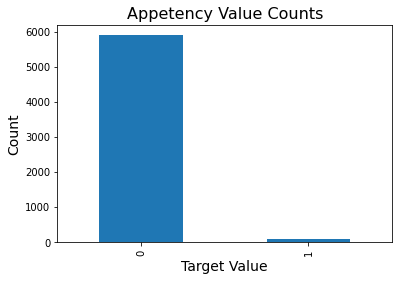

In [56]:
kdd_data['appetency_labels'].value_counts().plot( kind='bar')
plt.title("Appetency Value Counts", fontsize = 16)
plt.xlabel("Target Value", fontsize = 14)
plt.ylabel("Count",fontsize = 14 )
plt.show()

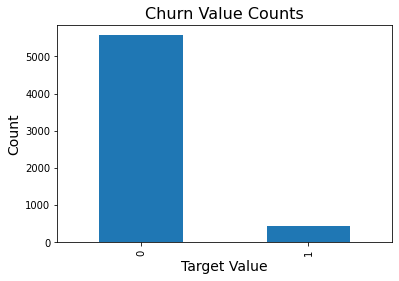

In [57]:
kdd_data['churn_labels'].value_counts().plot( kind='bar')
plt.title("Churn Value Counts", fontsize = 16)
plt.xlabel("Target Value", fontsize = 14)
plt.ylabel("Count", fontsize = 14)
plt.show()

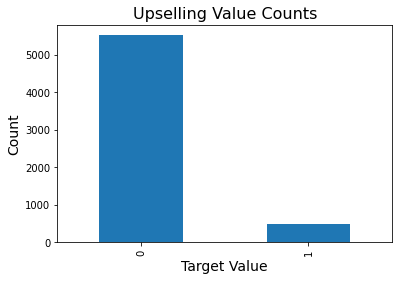

In [58]:
kdd_data['upselling_labels'].value_counts().plot( kind='bar')
plt.title("Upselling Value Counts", fontsize = 16)
plt.xlabel("Target Value", fontsize = 14)
plt.ylabel("Count", fontsize = 14)
plt.show()

# Handling categorical variables for processing

In [125]:
x = kdd_data.drop(['appetency_labels', 'churn_labels', 'upselling_labels'], axis =1)
y = kdd_data[['appetency_labels', 'churn_labels', 'upselling_labels']]
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=21)

In [127]:
def process_data(x_train, x_val):
  le=LabelEncoder()
  x_train['Var193']=le.fit_transform(x_train['Var193'])
  x_val['Var193'] = x_val['Var193'].map(lambda s: 'other' if s not in le.classes_ else s)
  le_classes = le.classes_.tolist()
  bisect.insort_left(le_classes, 'other')
  le.classes_ = le_classes
      
  x_val['Var193']=le.transform(x_val['Var193'])
      
  ohe=OneHotEncoder(handle_unknown='ignore')
  X_tr = ohe.fit_transform(x_train['Var193'].values.reshape(-1,1))
  X_te = ohe.transform(x_val['Var193'].values.reshape(-1,1))
  flag=0    
  for i in cols_new:
    
    if (flag!=0):

          le = LabelEncoder()
          x_train[i]=le.fit_transform(x_train[i])
          x_val[i] = x_val[i].map(lambda s: 'other' if s not in le.classes_ else s)
          le_classes = le.classes_.tolist()
          bisect.insort_left(le_classes, 'other')
          le.classes_ = le_classes
          x_val[i]=le.transform(x_val[i])
          ohe=OneHotEncoder(handle_unknown='ignore')
          print(i)
          x_train[i] = ohe.fit_transform(x_train[i])
          X_tei = ohe.transform(x_val[i].values.reshape(-1,1))
          X_tr=hstack((X_tr,X_tri))
          X_te=hstack((X_te,X_tei))

    flag=1

In [50]:
dummy_data = kdd_data[cols_new]

In [51]:
dummy_data = pd.get_dummies(dummy_data)


In [52]:
kdd_preprocessed = pd.concat([kdd_data[num_cols], dummy_data, kdd_data[targets]], axis = 1)

In [53]:
kdd_preprocessed.head()

,Var6,Var7,Var13,Var21,Var24,Var28,Var35,Var38,Var44,Var57,Var65,Var74,Var76,Var78,Var81,Var83,Var85,Var112,Var113,Var119,Var125,Var126,Var132,Var133,Var134,Var140,Var143,Var144,Var149,Var153,Var163,Var173,Var181,Var193_2Knk1KF,Var193_2wnefc9ISdLjfQoAYBI,Var193_5QKIjwyXr4MCZTEp7uAkS8PtBLcn,Var193_9U2tunPAje3TwfLLUQxzM3dC1ghn,Var193_AERks4l,Var193_BrRu5UxtiQY9TTJ8ABKpfS,Var193_ByQdnLRlFnny2k4AJzG,...,Var226_szEZ,Var226_uWr3,Var226_wX53,Var226_w_Ub,Var226_xb3V,Var227_02N6s8f,Var227_6fzt,Var227_RAYp,Var227_ZI9m,Var227_nIGXDli,Var227_nIGjgSB,Var227_vJ_w8kB,Var228_0pzBWGkV3fbsGZN52DH,Var228_4rd_,Var228_55YFVY9,Var228_6nxx00q6gnIF8ePJ3P3AEfZ1N,Var228_DU8B,Var228_F2FcTt7IdMT_v,Var228_F2FyR07IdsN7I,Var228_JnGLH58smNxIYcGK39k,Var228_NoEd,Var228_R4y5gQQWY8OodqDV,Var228_RjBDiL8f9CQYc21fICscNNpj6,Var228_SbOd7O8ky1wGNxp0Arj0Xs,Var228_TCU50_Yjmm6GIBZ0lL_,Var228_VjDE,Var228_WfJ2BB2SFSqauljlfOB,Var228_WfJYmPMksSqa1pajvfG,Var228_ZeaF,Var228_Zy3gnGM,Var228_am14IcfM7tWLrUmRT52KtA,Var228_b9qbUNk0dML_Mvi2,Var228_d0LtHjWeaXyArdN4sxU_saXqH,Var228_ib5G6X1eUxUn6,Var228_iyHGyLCEkQ,Var228_r_7E,Var228_xwM2aC7IdeMC0,appetency_labels,churn_labels,upselling_labels
0,1526.000000,7.0,184.0,464.000000,14.000000,166.56,0.0,3570.0,0.0,4.076907,9.0,35.0,1350864.0,0.0,7333.110000,5.0,12.0,168.0,117625.60,1175.000000,720.0,8.000000,0.0,1212385.0,69134.0,185.0,0.0,9.000000,397579.000000,1812252.0,38418.0,0.0,0.0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,525.000000,0.0,0.0,168.000000,2.000000,353.52,0.0,4764966.0,0.0,5.408032,9.0,0.0,2872928.0,3.0,151098.900000,25.0,2.0,40.0,-356411.60,590.000000,0.0,-0.241539,8.0,4136430.0,357038.0,0.0,0.0,9.000000,278334.000000,10439160.0,238572.0,0.0,0.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,5236.000000,7.0,904.0,1212.000000,26.000000,220.08,0.0,5883894.0,0.0,6.599658,9.0,518.0,1675776.0,0.0,16211.580000,40.0,58.0,336.0,405104.00,3230.000000,5967.0,-28.000000,0.0,3478905.0,248932.0,800.0,0.0,36.000000,320565.000000,9826360.0,434946.0,0.0,0.0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
3,1390.772846,0.0,0.0,237.688922,4.586656,22.08,0.0,0.0,0.0,1.988250,9.0,0.0,0.0,0.0,102342.502899,0.0,0.0,0.0,-275703.60,955.752518,0.0,-14.000000,0.0,0.0,0.0,0.0,0.0,11.552965,286174.983268,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1029.000000,7.0,3216.0,64.000000,4.000000,200.00,0.0,0.0,0.0,4.552446,18.0,224.0,784448.0,0.0,37423.500000,0.0,0.0,56.0,10714.84,215.000000,15111.0,58.000000,0.0,150650.0,66046.0,3255.0,0.0,9.000000,267162.000000,644836.0,0.0,0.0,0.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


# Base Models for churn using Logistic regression

In [99]:
# your code here 
s1 = x_train[y_train_churn==0]
s2 = x_train[y_train_churn==1]
m1 = s1.mean()
m2 = s2.mean()
std1 = s1.std()
std2 = s2.std()
n1 = len(s1)
n2 = len(s2)

In [100]:
t_stats = np.abs(m1-m2)/np.sqrt((std1**2/n1) + (std2**2/n2))

In [101]:
t_stats =  abs(t_stats).sort_values(ascending = False)

In [102]:
top15 = t_stats.index[:15]

In [103]:
print("The top 15 best predictors are", list(top15), sep = "\t")

The top 15 best predictors are	['Var65', 'Var7', 'Var74', 'Var140', 'Var13', 'Var44', 'Var113', 'Var144', 'Var76', 'Var126', 'Var81', 'Var119', 'Var24', 'Var21', 'Var78']


In [104]:
x_train_new = x_train[list(top15)]
x_val_new = x_val[list(top15)]

In [105]:
y_train_churn = y_train['churn_labels']

In [106]:
y_val_churn = y_val['churn_labels']

In [107]:
lreg_churn = LogisticRegression(random_state = 21)
lreg_churn.fit(x_train_new,y_train_churn)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=21, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [108]:
y_train_pred_churn = lreg_churn.predict(x_train_new)
y_val_pred_churn = lreg_churn.predict(x_val_new)

In [109]:
lreg_churn_probs = lreg_churn.predict_proba(x_val_new)
lreg_churn_probs = lreg_churn_probs[:, 1]

In [110]:
lr_auc_churn = roc_auc_score(y_val_churn, lreg_churn_probs)

In [111]:
print('Logistic: ROC AUC=%.3f' % (lr_auc_churn))

Logistic: ROC AUC=0.537


In [112]:
train_accuracy = accuracy_score(y_train_churn, y_train_pred_churn)
validation_accuracy = accuracy_score(y_val_churn, y_val_pred_churn)
print("Train Accuracy", np.round(train_accuracy,3))
print("Validation Accuracy", np.round(validation_accuracy,3))

Train Accuracy 0.926
Validation Accuracy 0.922


In [113]:
conf_matrix = confusion_matrix(y_val_churn, y_val_pred_churn)

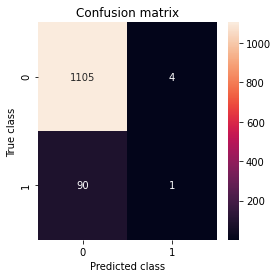

In [114]:
plt.figure(figsize=(4, 4))
sns.heatmap(conf_matrix,  annot=True,fmt="d")
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [115]:
tn, fp, fn, tp = confusion_matrix(y_val_churn, y_val_pred_churn).ravel()

In [116]:
recall_churn = tp/(tp + fn)

In [117]:
FNR_value = 1 - recall_churn

In [118]:
FNR_value

0.989010989010989

In [119]:
recall_churn

0.01098901098901099

In [120]:
roc_auc_score(y_train_churn, y_train_pred_churn)

0.5000075682989623

In [121]:
f1_churn = f1_score(y_train_churn, y_train_pred_churn)
print("f1 score is ", np.round(f1_churn,3))

f1 score is  0.006


# Base Model for Upselling

In [126]:
x = kdd_data.drop(['appetency_labels', 'churn_labels', 'upselling_labels'], axis =1)
y_ups = kdd_data['upselling_labels']
x_train, x_val, y_train_ups, y_val_ups = train_test_split(x, y_ups, test_size=0.2, random_state=21)

In [129]:
# your code here 
s1 = x_train[y_train_ups==0]
s2 = x_train[y_train_ups==1]
m1 = s1.mean()
m2 = s2.mean()
std1 = s1.std()
std2 = s2.std()
n1 = len(s1)
n2 = len(s2)

In [130]:
t_stats = np.abs(m1-m2)/np.sqrt((std1**2/n1) + (std2**2/n2))
t_stats =  abs(t_stats).sort_values(ascending = False)

In [131]:
best_pred = t_stats.index[0]
top15 = t_stats.index[:15]

In [132]:
print("The top 15 best predictors are", list(top15), sep = "\t")

The top 15 best predictors are	['Var28', 'Var126', 'Var113', 'Var81', 'Var153', 'Var38', 'Var133', 'Var85', 'Var144', 'Var134', 'Var35', 'Var24', 'Var112', 'Var76', 'Var7']


In [133]:
x_train_new = x_train[list(top15)]
x_val_new = x_val[list(top15)]

In [134]:
lreg_ups = LogisticRegression(random_state = 21)
lreg_ups.fit(x_train_new,y_train_ups)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=21, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [135]:
y_train_pred_ups = lreg_ups.predict(x_train_new)
y_val_pred_ups = lreg_ups.predict(x_val_new)

In [136]:
train_accuracy = accuracy_score(y_train_ups, y_train_pred_ups)
validation_accuracy = accuracy_score(y_val_ups, y_val_pred_ups)
print("Train Accuracy", np.round(train_accuracy,3))
print("Validation Accuracy", np.round(validation_accuracy,3))

Train Accuracy 0.921
Validation Accuracy 0.914


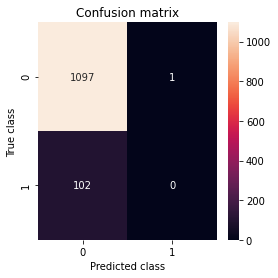

In [137]:
conf_matrix = confusion_matrix(y_val_ups, y_val_pred_ups)
plt.figure(figsize=(4, 4))
sns.heatmap(conf_matrix,  annot=True,fmt="d")
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [138]:
# generate a no skill prediction (majority class)
ns_ups_probs = [0] * len(x_val_new)

# predict probabilities
lreg_ups_probs = lreg_ups.predict_proba(x_val_new)
# keep probabilities for the positive outcome only
lreg_ups_probs = lreg_ups_probs[:, 1]
# calculate scores
ns_auc_ups = roc_auc_score(y_val_ups, ns_ups_probs)
lr_auc_ups = roc_auc_score(y_val_ups, lreg_ups_probs)

In [139]:
print('No Skill: ROC AUC=%.3f' % (ns_auc_ups))
print('Logistic: ROC AUC=%.3f' % (lr_auc_ups))

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.595


In [140]:
f1_ups = f1_score(y_train_ups, y_train_pred_ups)
print("f1 score is ", np.round(f1_ups,3))

f1 score is  0.0


# Base Model appentency

In [141]:
x = kdd_data.drop(['appetency_labels', 'churn_labels', 'upselling_labels'], axis =1)
y_app = kdd_data['upselling_labels']
x_train, x_val, y_train_app, y_val_app = train_test_split(x, y_app, test_size=0.2, random_state=21)

In [142]:
# your code here 
s1 = x_train[y_train_app==0]
s2 = x_train[y_train_app==1]
m1 = s1.mean()
m2 = s2.mean()
std1 = s1.std()
std2 = s2.std()
n1 = len(s1)
n2 = len(s2)

In [143]:
t_stats = np.abs(m1-m2)/np.sqrt((std1**2/n1) + (std2**2/n2))
t_stats =  abs(t_stats).sort_values(ascending = False)

In [144]:
best_pred = t_stats.index[0]
top15 = t_stats.index[:15]

In [145]:
print("The top 15 best predictors are", list(top15), sep = "\t")

The top 15 best predictors are	['Var28', 'Var126', 'Var113', 'Var81', 'Var153', 'Var38', 'Var133', 'Var85', 'Var144', 'Var134', 'Var35', 'Var24', 'Var112', 'Var76', 'Var7']


In [146]:
x_train_new = x_train[list(top15)]
x_val_new = x_val[list(top15)]

In [147]:
lreg_app = LogisticRegression(random_state = 21)
lreg_app.fit(x_train_new,y_train_app)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=21, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [148]:
y_train_pred_app = lreg_app.predict(x_train_new)
y_val_pred_app = lreg_app.predict(x_val_new)

In [149]:
train_accuracy = accuracy_score(y_train_app, y_train_pred_app)
validation_accuracy = accuracy_score(y_val_app, y_val_pred_app)
print("Train Accuracy", np.round(train_accuracy,3))
print("Validation Accuracy", np.round(validation_accuracy,3))

Train Accuracy 0.921
Validation Accuracy 0.914


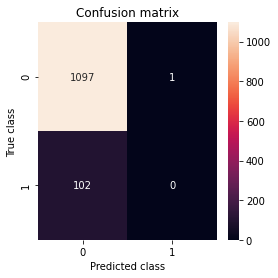

In [150]:
conf_matrix = confusion_matrix(y_val_app, y_val_pred_app)
plt.figure(figsize=(4, 4))
sns.heatmap(conf_matrix,  annot=True,fmt="d")
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [151]:
# generate a no skill prediction (majority class)
ns_app_probs = [0] * len(x_val_new)

# predict probabilities
lreg_app_probs = lreg_app.predict_proba(x_val_new)
# keep probabilities for the positive outcome only
lreg_app_probs = lreg_app_probs[:, 1]

# calculate scores
ns_auc_app = roc_auc_score(y_val_app, ns_app_probs)
lr_auc_app = roc_auc_score(y_val_app, lreg_app_probs)

In [152]:
print('No Skill: ROC AUC=%.3f' % (ns_auc_app))
print('Logistic: ROC AUC=%.3f' % (lr_auc_app))

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.595


In [153]:
f1_app = f1_score(y_val_app, y_val_pred_app)
print("f1 score is ", np.round(f1_app,3))

f1 score is  0.0


# Data to csv

In [156]:
kdd_preprocessed.to_csv('kdd_preprocessed.csv')

In [157]:
kdd_preprocessed.head()

,Var6,Var7,Var13,Var21,Var24,Var28,Var35,Var38,Var44,Var57,Var65,Var74,Var76,Var78,Var81,Var83,Var85,Var112,Var113,Var119,Var125,Var126,Var132,Var133,Var134,Var140,Var143,Var144,Var149,Var153,Var163,Var173,Var181,Var193_2Knk1KF,Var193_2wnefc9ISdLjfQoAYBI,Var193_5QKIjwyXr4MCZTEp7uAkS8PtBLcn,Var193_9U2tunPAje3TwfLLUQxzM3dC1ghn,Var193_AERks4l,Var193_BrRu5UxtiQY9TTJ8ABKpfS,Var193_ByQdnLRlFnny2k4AJzG,...,Var226_szEZ,Var226_uWr3,Var226_wX53,Var226_w_Ub,Var226_xb3V,Var227_02N6s8f,Var227_6fzt,Var227_RAYp,Var227_ZI9m,Var227_nIGXDli,Var227_nIGjgSB,Var227_vJ_w8kB,Var228_0pzBWGkV3fbsGZN52DH,Var228_4rd_,Var228_55YFVY9,Var228_6nxx00q6gnIF8ePJ3P3AEfZ1N,Var228_DU8B,Var228_F2FcTt7IdMT_v,Var228_F2FyR07IdsN7I,Var228_JnGLH58smNxIYcGK39k,Var228_NoEd,Var228_R4y5gQQWY8OodqDV,Var228_RjBDiL8f9CQYc21fICscNNpj6,Var228_SbOd7O8ky1wGNxp0Arj0Xs,Var228_TCU50_Yjmm6GIBZ0lL_,Var228_VjDE,Var228_WfJ2BB2SFSqauljlfOB,Var228_WfJYmPMksSqa1pajvfG,Var228_ZeaF,Var228_Zy3gnGM,Var228_am14IcfM7tWLrUmRT52KtA,Var228_b9qbUNk0dML_Mvi2,Var228_d0LtHjWeaXyArdN4sxU_saXqH,Var228_ib5G6X1eUxUn6,Var228_iyHGyLCEkQ,Var228_r_7E,Var228_xwM2aC7IdeMC0,appetency_labels,churn_labels,upselling_labels
0,1526.000000,7.0,184.0,464.000000,14.000000,166.56,0.0,3570.0,0.0,4.076907,9.0,35.0,1350864.0,0.0,7333.110000,5.0,12.0,168.0,117625.60,1175.000000,720.0,8.000000,0.0,1212385.0,69134.0,185.0,0.0,9.000000,397579.000000,1812252.0,38418.0,0.0,0.0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,525.000000,0.0,0.0,168.000000,2.000000,353.52,0.0,4764966.0,0.0,5.408032,9.0,0.0,2872928.0,3.0,151098.900000,25.0,2.0,40.0,-356411.60,590.000000,0.0,-0.241539,8.0,4136430.0,357038.0,0.0,0.0,9.000000,278334.000000,10439160.0,238572.0,0.0,0.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,5236.000000,7.0,904.0,1212.000000,26.000000,220.08,0.0,5883894.0,0.0,6.599658,9.0,518.0,1675776.0,0.0,16211.580000,40.0,58.0,336.0,405104.00,3230.000000,5967.0,-28.000000,0.0,3478905.0,248932.0,800.0,0.0,36.000000,320565.000000,9826360.0,434946.0,0.0,0.0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
3,1390.772846,0.0,0.0,237.688922,4.586656,22.08,0.0,0.0,0.0,1.988250,9.0,0.0,0.0,0.0,102342.502899,0.0,0.0,0.0,-275703.60,955.752518,0.0,-14.000000,0.0,0.0,0.0,0.0,0.0,11.552965,286174.983268,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1029.000000,7.0,3216.0,64.000000,4.000000,200.00,0.0,0.0,0.0,4.552446,18.0,224.0,784448.0,0.0,37423.500000,0.0,0.0,56.0,10714.84,215.000000,15111.0,58.000000,0.0,150650.0,66046.0,3255.0,0.0,9.000000,267162.000000,644836.0,0.0,0.0,0.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
